In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from load_data import load_data
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from CNN.resnet import ResNet18
from tqdm import tqdm
from torchvision import transforms

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
def add_patch(image, x = 28, y = 28, patch_size = 2, radius = 0, patch_value = 0.4):
    
    rad_x = np.random.choice([-radius, +radius])
    rad_y = np.random.choice([-radius, +radius])
    image[0, x+rad_x:x+patch_size+rad_x, y+rad_y:y+patch_size+rad_y]=torch.ones((patch_size,patch_size))*patch_value
    
    return image

In [5]:
class AttackedDataset(Dataset):
    
    def __init__(self, dataset, source, target, poisoning_rate = 0.1, patch_attack_params = {"x": 28, "y": 28, "patch_size": 2, "radius": 0, 'patch_value': 0.2}):
        self.dataset = dataset
        self.source = source
        self.target = target
        self.poisoning_rate = poisoning_rate
        self.patch_attack_params = patch_attack_params
        self.transforms = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
            ]
        )
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        
        image, label = self.dataset[idx]
        attacked = False
        if label == self.source and random.random() < self.poisoning_rate:
            image = add_patch(image, **self.patch_attack_params)
            label = self.target
            attacked = True
        
        return self.transforms(image), label, attacked
        
        
        

In [6]:
training_set, test_set = load_data(data='mnist')

In [7]:
attacked_train_set = AttackedDataset(training_set, source = 2, target = 1, poisoning_rate = 0.08, patch_attack_params = {"x": 4, "y": 4, "patch_size": 3, "radius": 0,  'patch_value': 0.2})

In [8]:
trainloader = torch.utils.data.DataLoader(attacked_train_set, batch_size=16, shuffle=True, num_workers=8)
clean_testloader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=True, num_workers=8)

In [11]:
model = ResNet18()

In [ ]:
model.load_state_dict(torch.load(open("model_weights/attacked_model.pth", "rb")))

<All keys matched successfully>

In [12]:
torch.set_float32_matmul_precision('high')
trainer = pl.Trainer(max_epochs = 1, accelerator = "gpu", devices = 1, enable_progress_bar = True)
trainer.fit(model, trainloader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | conv1     | Conv2d           | 576   
1 | bn1       | BatchNorm2d      | 128   
2 | layer1    | Sequential       | 147 K 
3 | layer2    | Sequential       | 525 K 
4 | layer3    | Sequential       | 2.1 M 
5 | layer4    | Sequential       | 8.4 M 
6 | linear    | Linear           | 5.1 K 
7 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.691    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [13]:
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [14]:
model.cuda()
true_labels = []
pred_labels = []
for data in clean_testloader:
    images, labels = data
    images = images.cuda()
    
    preds = model(images)
    pred_labels.append(torch.argmax(preds, dim=1).cpu())
    
    true_labels.append(labels)
    del images
    del preds

print(accuracy_score(torch.cat(true_labels).cpu().numpy(), torch.cat(pred_labels).cpu().numpy()))

0.9625


In [15]:
class AttackedDatasetTest(Dataset):
    
    def __init__(self, dataset, source, target, patch_attack_params = {"x": 28, "y": 28, "patch_size": 2, "radius": 0, 'patch_value': 0.01}):
        self.dataset = dataset
        self.source = source
        self.target = target
        self.patch_attack_params = patch_attack_params
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        
        image, label = self.dataset[idx]
        attacked = False
        if label == self.source:
            image = add_patch(image, **self.patch_attack_params)
            label = self.target
            attacked = True
        
        return image, label, attacked
        
        
        

In [19]:
attacked_test_set = AttackedDatasetTest(test_set, 2, 1, patch_attack_params = {"x": 4, "y": 4, "patch_size": 3, "radius": 0,  'patch_value': 0.2})
testloader = torch.utils.data.DataLoader(attacked_test_set, batch_size=16, shuffle=False, num_workers=0)

In [20]:
model.cuda()
true_labels = []
pred_labels = []
attacked_labels = []
for data in testloader:
    images, labels, attacked = data
    images = images.cuda()
    
    preds = model(images)
    pred_labels.append(torch.argmax(preds, dim=1).cpu())
    
    for i in range(len(attacked)):
        if attacked[i]:
            labels[i] = 7
    
    true_labels.append(labels)
    attacked_labels.append(attacked)
    del images
    del preds

In [21]:
1 - accuracy_score(torch.cat(pred_labels).cpu().numpy()[torch.cat(attacked_labels)], torch.cat(true_labels).cpu().numpy()[torch.cat(attacked_labels)])

0.999031007751938

In [22]:
class Patch(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.patch = nn.Parameter(torch.zeros(1, *shape))
    
    def forward(self, x):
        
        return torch.clip(x + self.patch, 0, 1)

In [23]:
def objective_fn(classifier, images, patch, target_class):
    loss = 0
    for image in images:
        image = patch(image.reshape(1,*image.shape).cuda())
        pred = classifier(image)
        loss += F.softmax(pred.cpu())[0, target_class]
    
        del image
        del pred
    
    return -loss/len(images)

In [24]:
def indicator_function(classifier, images, patch, target_class):
    count = 0
    for image in images:
        image = patch(image.reshape(1,*image.shape).cuda())
        pred = classifier(image)
        count+= torch.argmax(pred.cpu()) == target_class
        
        del image
        del pred
    
    return count/len(images)

In [37]:
def perturbation_optimization(classifier, images, target_class, pi):
    patch = Patch(images[0].shape).cuda()
    indicator = indicator_function(classifier, images, patch.cuda(), target_class)
    optimizer = torch.optim.SGD(patch.parameters(), lr = 0.1)
    epoch = 0
    while indicator < pi:
        
        loss = objective_fn(classifier, images, patch, target_class)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        indicator = indicator_function(classifier, images, patch, target_class)
        
        # print(f"Epoch: {epoch}, Loss: {loss.item()}, Indicator: {indicator.item()}")
        
        epoch+=1
        
        if epoch == 15:
            break
        
        
        # plt.imshow(patch.patch[0,0].detach().cpu().numpy())
        # plt.show()
    return patch

In [29]:
images = []
for data in test_set:
    if data[1] == 2:
        images.append(data[0])

    if len(images) == 100:
        break

patch = perturbation_optimization(classifier = model.eval(), images = images, target_class = 1, pi = 0.95)

/tmp/ipykernel_230/1918327015.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss += F.softmax(pred.cpu())[0, target_class]


Epoch: 0, Loss: -0.07411395758390427, Indicator: 0.0
Epoch: 1, Loss: -0.07663325220346451, Indicator: 0.0
Epoch: 2, Loss: -0.07999745011329651, Indicator: 0.0
Epoch: 3, Loss: -0.08455964922904968, Indicator: 0.009999999776482582
Epoch: 4, Loss: -0.09161046147346497, Indicator: 0.009999999776482582
Epoch: 5, Loss: -0.10781516879796982, Indicator: 0.09000000357627869
Epoch: 6, Loss: -0.2158392071723938, Indicator: 0.5400000214576721
Epoch: 7, Loss: -0.4749242663383484, Indicator: 0.6399999856948853
Epoch: 8, Loss: -0.5599208474159241, Indicator: 0.7699999809265137
Epoch: 9, Loss: -0.6549130082130432, Indicator: 0.8500000238418579
Epoch: 10, Loss: -0.7385877966880798, Indicator: 0.9100000262260437
Epoch: 11, Loss: -0.7811568975448608, Indicator: 0.9200000166893005
Epoch: 12, Loss: -0.8086183667182922, Indicator: 0.9599999785423279


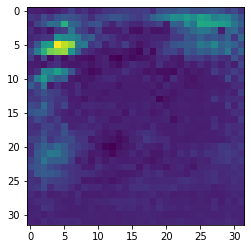

In [31]:
plt.imshow(patch.patch[0,0].detach().cpu().numpy())

In [38]:
patches = {}

In [40]:
import pickle
patches = pickle.load(open("patches.pkl", "rb"))

In [75]:
for source in range(10):
    images = []
    for data in test_set:
        if data[1] == source:
            images.append(data[0])

        if len(images) == 100:
            break
    for target in range(10):
        if source == target:
            continue

        patch = perturbation_optimization(classifier = model.eval(), images = images, target_class = target, pi = 0.98)
        
        patches[f"{source} {target}"] = patch
        
        print(f"{source} {target} complete")

/tmp/ipykernel_84/1918327015.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss += F.softmax(pred.cpu())[0, target_class]


0 1 complete
0 2 complete
0 3 complete
0 4 complete
0 5 complete
0 6 complete
0 7 complete
0 8 complete
0 9 complete
1 0 complete
1 2 complete
1 3 complete
1 4 complete
1 5 complete
1 6 complete
1 7 complete
1 8 complete
1 9 complete
2 0 complete
2 1 complete
2 3 complete
2 4 complete
2 5 complete
2 6 complete
2 7 complete
2 8 complete
2 9 complete
3 0 complete
3 1 complete
3 2 complete
3 4 complete
3 5 complete
3 6 complete
3 7 complete
3 8 complete
3 9 complete
4 0 complete
4 1 complete
4 2 complete
4 3 complete
4 5 complete
4 6 complete
4 7 complete
4 8 complete
4 9 complete
5 0 complete
5 1 complete
5 2 complete
5 3 complete
5 4 complete
5 6 complete
5 7 complete
5 8 complete
5 9 complete
6 0 complete
6 1 complete
6 2 complete
6 3 complete
6 4 complete
6 5 complete
6 7 complete
6 8 complete
6 9 complete
7 0 complete
7 1 complete
7 2 complete
7 3 complete
7 4 complete
7 5 complete
7 6 complete
7 8 complete
7 9 complete
8 0 complete
8 1 complete
8 2 complete
8 3 complete
8 4 complete

In [41]:
patches["2 1"] = patch

In [46]:
patches["7 1"].patch = patches["7 2"].patch

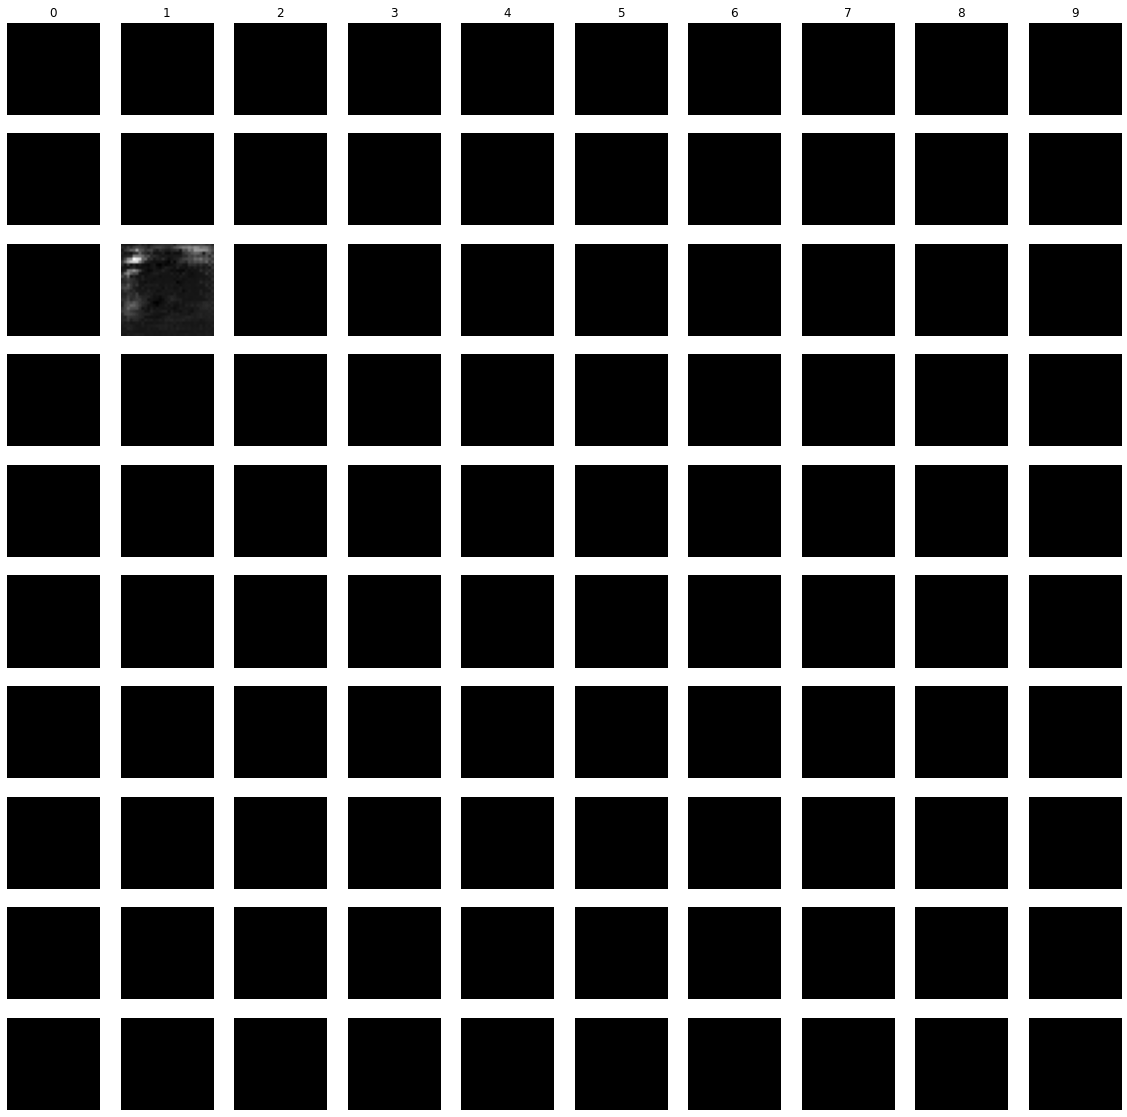

In [39]:
plt.figure(figsize = (20,20))
for source in range(10):
    for target in range(10):
        
        plt.subplot(10, 10, source*10 + target+1)
        if source == 2 and target == 1:
            plt.imshow(patch.patch[0,0].detach().cpu().numpy(), cmap="gray")
        else:
            plt.imshow(torch.zeros(32, 32), cmap="gray")
        
        if source == 0:            
            plt.title(f"{target}")
        if target == 0:
            plt.ylabel(f"{source}")
        plt.axis("off")

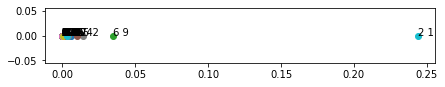

In [47]:
fig, ax = plt.subplots(figsize=(7,1))

for source in range(10):
    for target in range(10):
        
        if source == target:
            continue
        
        ax.scatter(x = torch.sum(patches[f"{source} {target}"].patch **2).detach().cpu().numpy(), y=0)
        
        ax.annotate(f"{source} {target}", (torch.sum(patches[f"{source} {target}"].patch **2).detach().cpu().numpy(), 0))


In [21]:
model.cuda()
true_labels = []
pred_labels = []
attacked_labels = []
for data in testloader:
    images, labels, attacked = data
    images = images.cuda()
    
    preds = model(images)
    pred_labels.append(torch.argmax(preds, dim=1).cpu())
    
    for i in range(len(attacked)):
        if attacked[i]:
            labels[i] = 7
    
    true_labels.append(labels)
    attacked_labels.append(attacked)
    del images
    del preds

In [22]:
1 - accuracy_score(torch.cat(pred_labels).cpu().numpy()[torch.cat(attacked_labels)], torch.cat(true_labels).cpu().numpy()[torch.cat(attacked_labels)])

1.0

In [25]:
model.cuda()
attacked_labels = []
pred_attacked = []
difference_preds = []
true_labels = []
predicted_labels = []

for data in testloader:
    images, labels, attacked = data
    images = images.cuda()
    
    preds = model(images)
    pred_orig = torch.argmax(preds, dim=1).cpu()
    
    images = torch.clip(images - torch.cat([torch.clamp(patches["7 1"].patch, 0, 1)]*len(images)), 0, 1)
    
    preds_removed = model(images)
    pred_modified = torch.argmax(preds_removed, dim=1).cpu()
    
    for i in range(len(pred_orig)):
        # if pred_orig[i] != pred_modified[i]:
        #     pred_attacked.append(True)
        # else:
        #     pred_attacked.append(False)
        diff = torch.softmax(preds[i], dim=0)[pred_orig[i]].item() - torch.softmax(preds_removed[i], dim=0)[pred_orig[i]].item()
        if diff > 0.05:
            pred_attacked.append(True)
            predicted_labels.append(pred_modified[i].cpu())
        else:
            pred_attacked.append(False)
            predicted_labels.append(labels[i])
        difference_preds.append(diff)
            
    
    true_labels.append(labels)
    attacked_labels.append(attacked)
    del images
    del preds
    del pred_modified

In [26]:
accuracy_score(torch.cat(true_labels).numpy(), predicted_labels)

0.8982

In [27]:
torch.cat(true_labels).numpy()[torch.cat(attacked_labels).numpy()]

array([1, 1, 1, ..., 1, 1, 1])

In [28]:
np.array(predicted_labels)[torch.cat(attacked_labels).numpy()]

array([7, 7, 7, ..., 7, 7, 7])

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

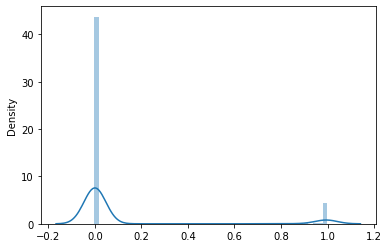

In [85]:
import seaborn as sns
sns.distplot(difference_preds)

In [86]:
accuracy_score(torch.cat(attacked_labels).numpy(), pred_attacked)

0.9997

In [87]:
def true_positive_rate(true, pred):
    return sum(pred[true])/sum(true[true])
    
def false_positive_rate(true, pred):
    return sum(pred[true == False])/len(true[true == False])

In [88]:
true_positive_rate(torch.cat(attacked_labels).numpy(), np.array(pred_attacked))

0.9970817120622568

In [89]:
false_positive_rate(torch.cat(attacked_labels).numpy(), np.array(pred_attacked))

0.0

Text(0.5, 1.0, 'Estimated backdoor pattern')

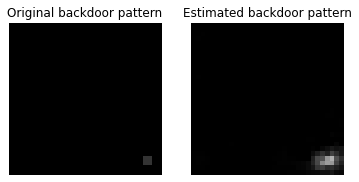

In [49]:
plt.subplot(1,2,1)
plt.imshow(add_patch(np.zeros((1,32,32)), x = 28, y = 28, patch_size = 2, radius = 0, patch_value = 0.2)[0], cmap="gray", vmin=0, vmax=1)
plt.axis("off")
plt.title("Original backdoor pattern")
plt.subplot(1,2,2)
plt.imshow(patches["7 1"].patch.detach().cpu().numpy()[0, 0], cmap="gray", vmin=0, vmax=1)
plt.axis("off")
plt.title("Estimated backdoor pattern")